# Assignment 3
### Tyler Young | 260730324
### April. 3, 2020

In [304]:
# imports
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

## Part 1: Segmentation

### 1.1 K-Means Clustering

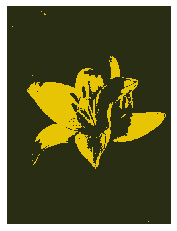

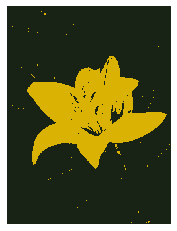

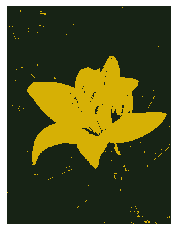

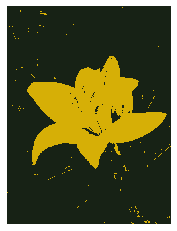

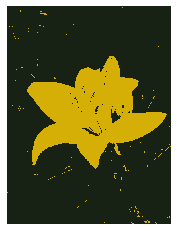

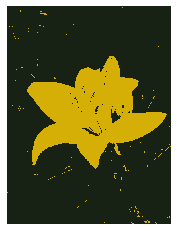

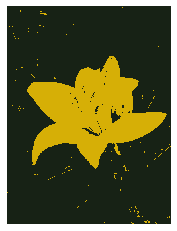

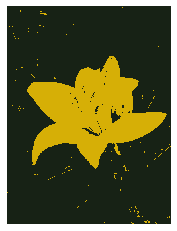

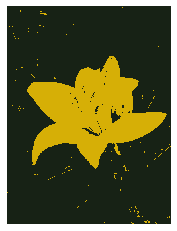

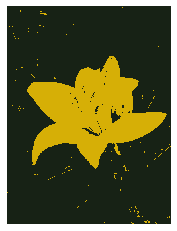

In [305]:
# import images
imglily = cv2.imread('yellowlily.png')
imglily = cv2.cvtColor(imglily, cv2.COLOR_BGR2RGB)
Z = imglily.reshape((-1,3))

normalized = Z/255
k = 2
centers = np.random.random_sample((k, 3))
iteration = []
result = []

for ite in range(10):
    
    # compute the distance between each pixel and cluster center
    d = np.array([normalized - c for c in centers])
    d = np.linalg.norm(d, axis=-1)
        
    # assign a pixel to the cluster
    clusters = np.argmin(d, axis=0)
    iteration.append(clusters)
        
    # compute new cluster centers
    newc = np.empty(shape=(k,3))
    for c in range(k):
        np.mean(normalized[clusters == c], axis=0, out=newc[c])
    centers = newc

    # form images
    img = np.empty_like(normalized)
    
    for i in range(img.shape[0]):
        img[i] = centers[clusters[i]]
    result.append(img)
    
# plot iterations
for i in range(10):
    plt.imshow(result[i].reshape(imglily.shape)), plt.axis('off')
    plt.show()

### 1.2 Expectation Maximization

In [317]:
# function to compute the probability of association with a Gaussian distribution
def gauss(x, mu, std):
    
    num = math.e**(-0.5 * np.power((x - mu)/ std, 2))
    denom = math.sqrt(2 * math.pi) * std
    prob = np.linalg.norm(num/denom, axis=-1)
    
    return prob

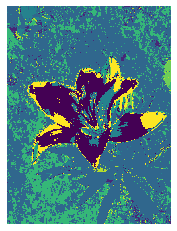

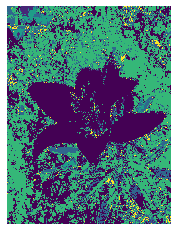

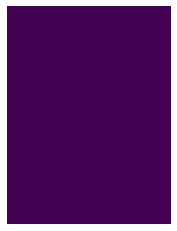

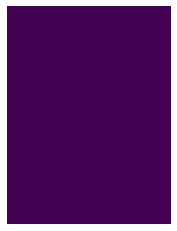

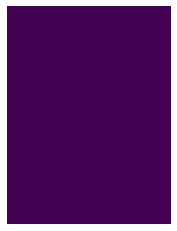

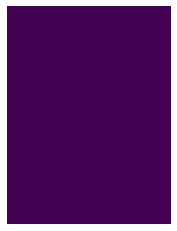

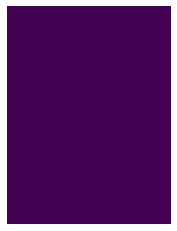

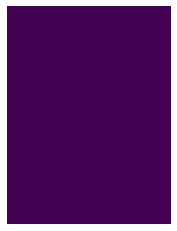

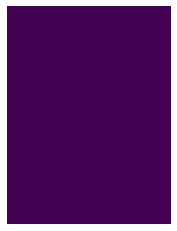

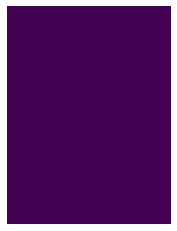

In [320]:
# Expectation maximization function
h, w, ch = imglily.shape
imglily = imglily.astype(np.float64)

# defining Gaussian parameters and other variables
mus = np.random.random((k, 3)) * 255.0
probs = np.full((k), (1.0 / k))
std = np.full((k, ch), (255.0 / k))
result = []

# ten iterations of EM
for it in range(10):
        
    # E-step
    exp = np.empty(shape=(h, w, k))
    for i in range(h):
        for j in range(w): 
            exp[i][j] = gauss(imglily[i][j], mus, std)
        
    denom = np.sum(exp * probs, axis=-1)
    denom = denom.reshape((h, w, 1))
    exp = exp / denom
        
    # draw clusters
    clusters = np.argmax(exp, axis=-1)
    result.append(clusters)
        
    # M-step 
    for c in range(k): 
        e = 0
        for i in range(h):
            for j in range(w): 
                e += exp[i, j, c] * imglily[i, j]
        mus[c] = e / np.sum(exp[:,:,c])
        curr = imglily[clusters==c]
        std[c] = np.sqrt(np.var(curr, axis=0))
        probs[c] = np.size(curr) / np.size(imglily)
        
# plot iterations
for i in range(10):
    plt.imshow(result[i]), plt.axis('off')
    plt.show()

### 1.3 Reasoning Question

When the there is a tighter clustering of data points. This will allow for both methods to create similar solutions in that outliers have a smaller affect on the clustering. Specifically for the Gaussian distribution, outliers will have a smaller likelihood of being included in the Gaussian's cluster. And for the K-means method, because it's clusters are dealt with in a manner such that only nearby points are classified together, outliers would be excluded. Therefore, this is when the K-means and the EM will give the same solution provided similar initializations. 

## Part 2: Stereo Vision

### 2.1 Depth Estimation

In [308]:
# Drawlines function taken from Tutorial 7
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col, ch = img1.shape
    
    img1 = np.copy(img1)
    img2 = np.copy(img2)
    
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

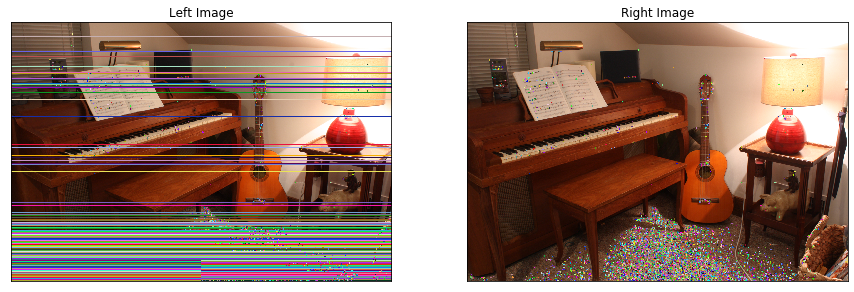

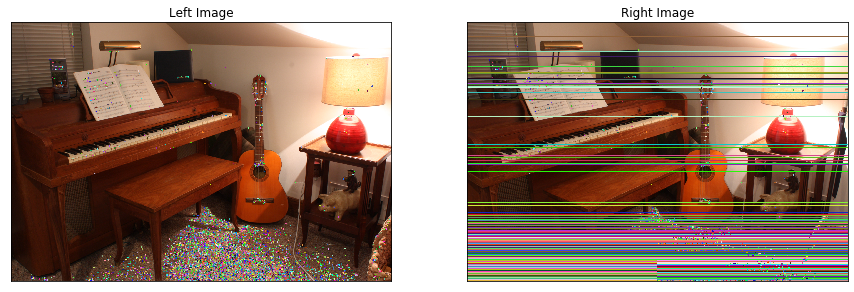

In [309]:
# load left and right images
imgL = cv2.imread("piano.png")
imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
imgR = cv2.imread("piano2.png")
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# Now, we want to match keypoints and remove matches on repeatative structure.
# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2) # query image, train image

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.5 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS) 
# epipolar line in Right image = F ptsL (matrix multiplication)
# epipolar line in Left image = F' ptsR (matrix multiplication)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

In [310]:
# function to find the normalized cross correlation value as specified in lecture 13 slide 57
def normcrosscor(patchl, patchr):
    num = 0
    denom1 = 0
    denom2 = 0
    patchl = patchl.astype(np.int64)
    patchr = patchr.astype(np.int64)
    
    for i in range(5):
        for j in range(5):
            for k in range(3):
                num += patchl[i,j,k]*patchr[i,j,k]
                denom1 += (patchl[i,j,k]**2) 
                denom2 += (patchr[i,j,k]**2)
                
    return num/(denom1*denom2)**0.5

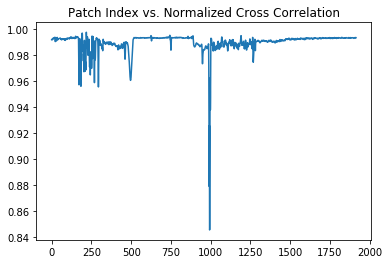

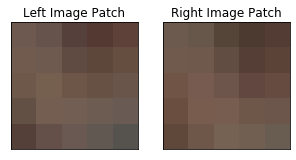

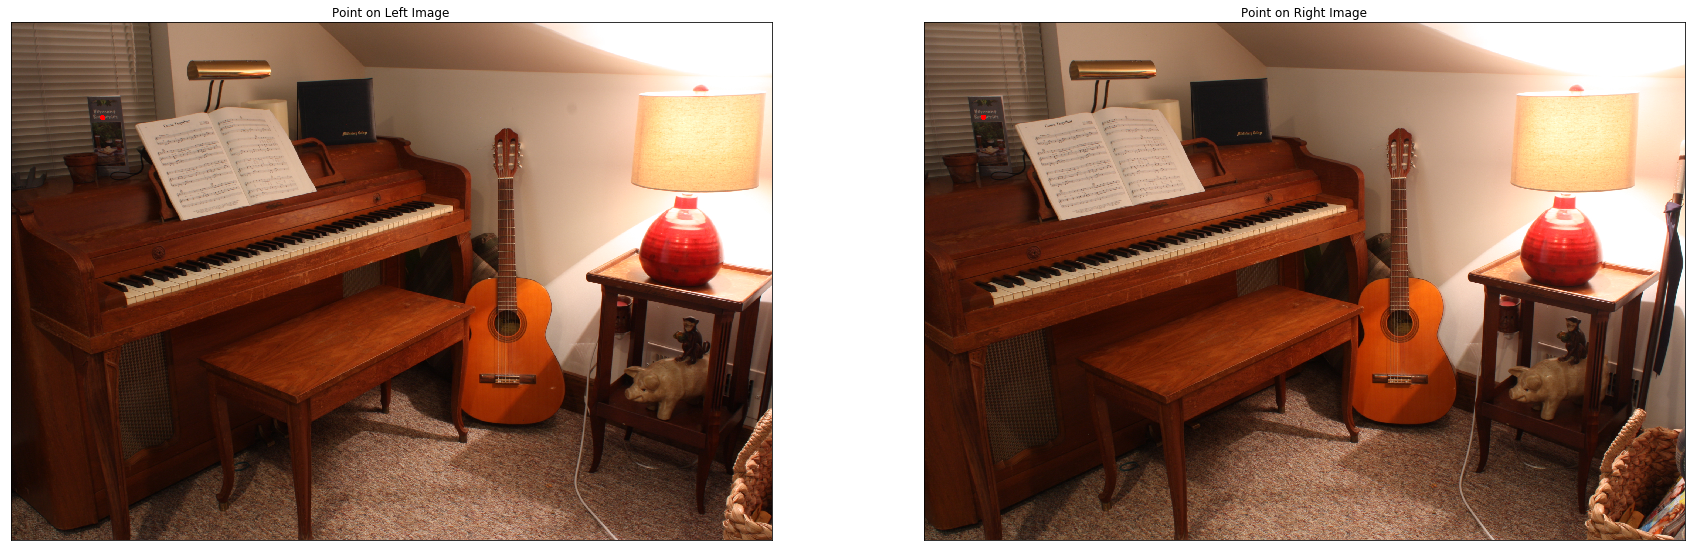

In [311]:
# select a random keypoint
point = 41
key = ptsL[point]

# create a 5x5 patch
patchl = imgL[key[1]-2:key[1]+3, key[0]-2:key[0]+3,:]

lineL = linesR[point]

# define the epipolar line
x0, y0 = map(int, [0, -lineL[2]/lineL[1]])
slope = lineL[0]/lineL[1]

# create variables for storing patch info
crosscorrelations = np.zeros(imgL.shape[0] - 5)
patches = np.empty((imgL.shape[0] - 5, 5, 5, 3), dtype = np.uint8)
patchcenter = np.empty((imgL.shape[0] - 5, 2), dtype = np.int64)

# create patches in the right image along the line
for i in range(2, imgL.shape[0] - 3):
    x = int(x0 + i)
    y = int(y0 + slope * (i - x0))
    
    patchr = imgR[y - 2 : y + 3, x - 2 : x + 3, :]
    patches[i - 2] = patchr
    crosscorrelations[i - 2] = normcrosscor(patchl, patchr)
    patchcenter[i - 2][0] = x
    patchcenter[i - 2][1] = y

# plot the cross correlation values versus the index
plt.plot(crosscorrelations)
plt.title("Patch Index vs. Normalized Cross Correlation")
plt.show()

MAX_VAL = np.amax(crosscorrelations)
maxes = np.argwhere(crosscorrelations == MAX_VAL)

patchr = patches[maxes[0][0]]

# plot patches
plt.figure(figsize = (5, 5))
plt.subplot(121), plt.imshow(patchl)
plt.title("Left Image Patch"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(patchr)
plt.title("Right Image Patch"), plt.xticks([]), plt.yticks([])
plt.show()

pointr = patchcenter[maxes[0]][0]

# draw points
keypointl = cv2.circle(imgL.copy(), tuple(key), 10, (255, 0, 0), -1)
keypointr = cv2.circle(imgR.copy(), tuple(pointr), 10, (255, 0, 0), -1)

# plot images with points identified
plt.figure(figsize = (30, 15))
plt.subplot(121), plt.imshow(keypointl)
plt.title("Point on Left Image"), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(keypointr)
plt.title("Point on Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Testing out different keypoints in the left image, there are in fact more than one matching points. The matching point I found seems to be pretty spot on, between both images it's in the same area and the patch themselves look very similar. Therefore, I believe that the keypoint matched. That being said, while trying to find this point, I encountered many non-matching points. So, it's not to say that every point selected from the left matches correctly with the right using the methods examined. There would are likely many matching points but, with hundreds to go through, I settled on one that I found gave a satisfactory match.

## Part 3: Motion Algorithm

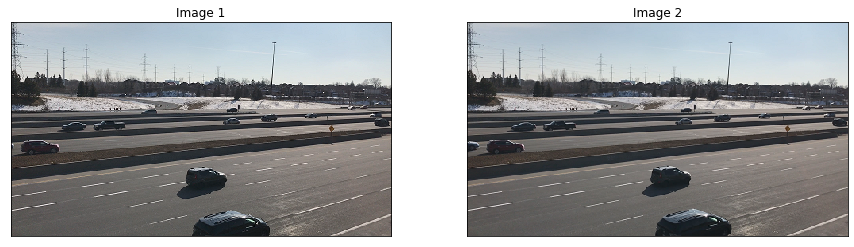

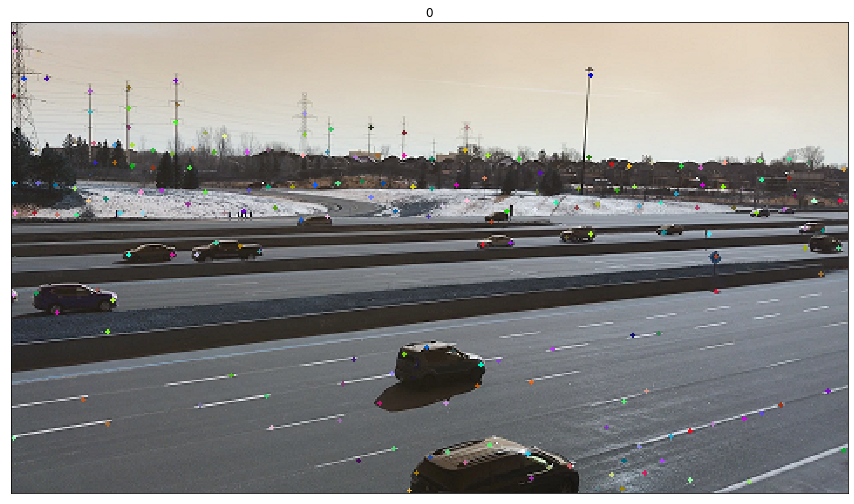

Error Mean:  7.75061


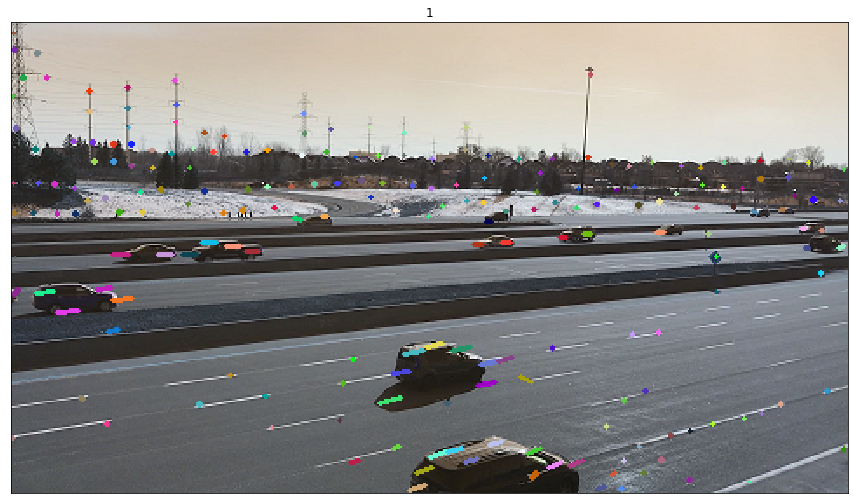

Error Mean:  3.8921938


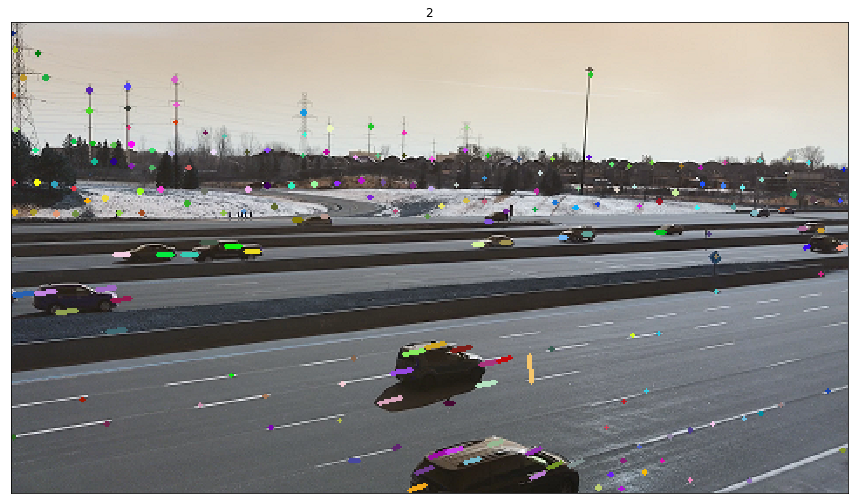

Error Mean:  3.4979928


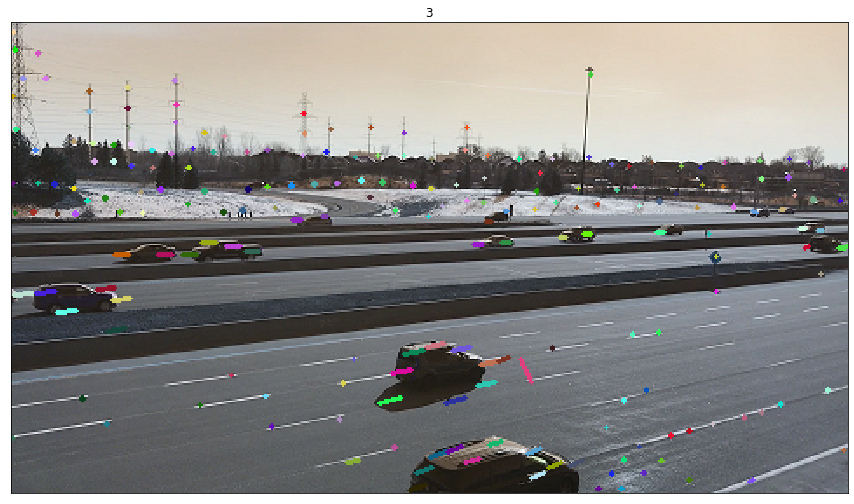

Error Mean:  3.3947105


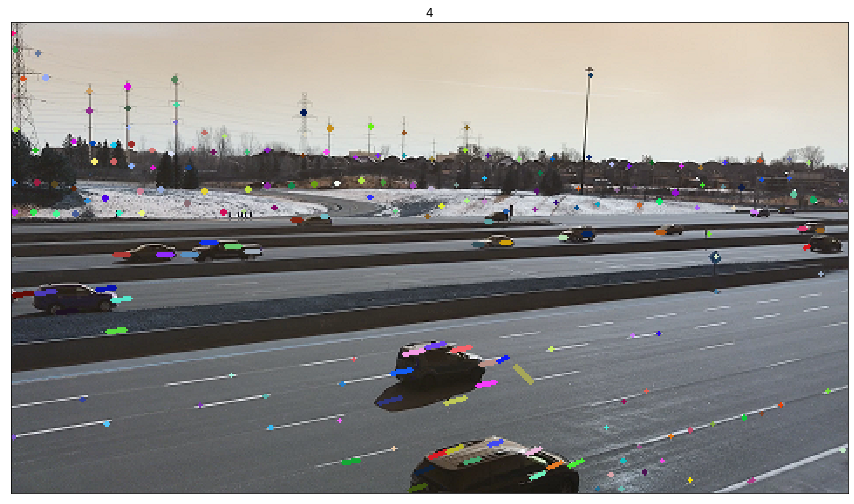

Error Mean:  3.455747


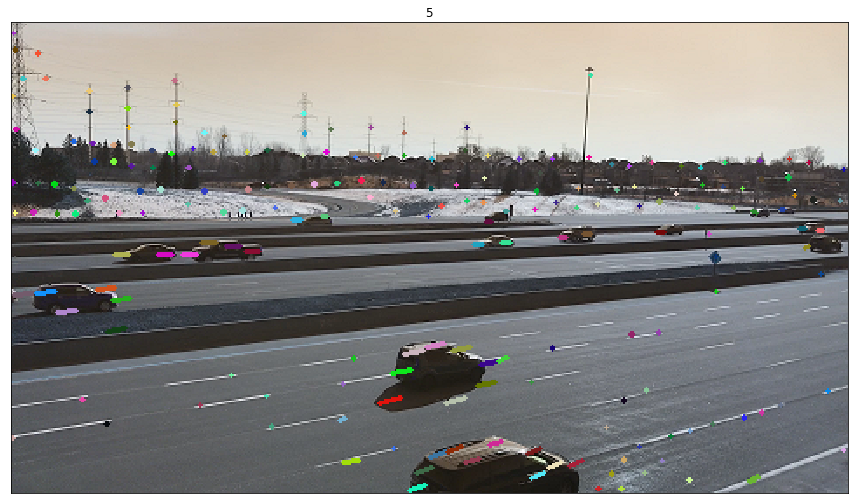

Error Mean:  3.4579716


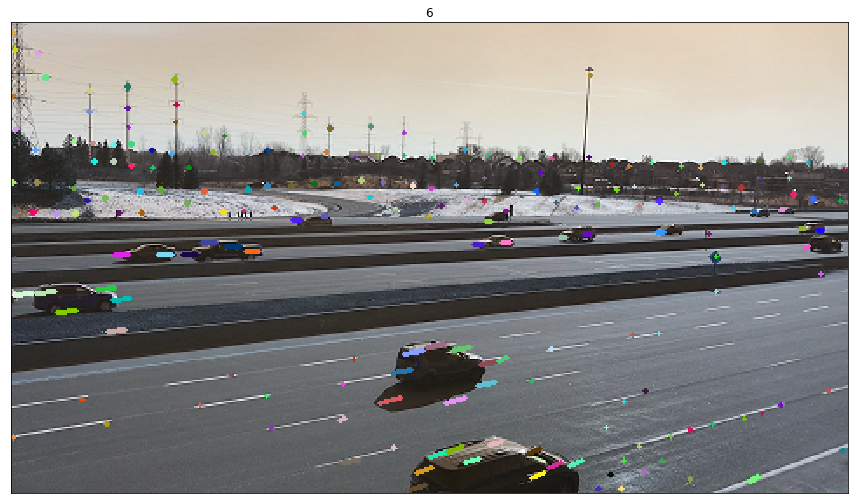

Error Mean:  3.5221632


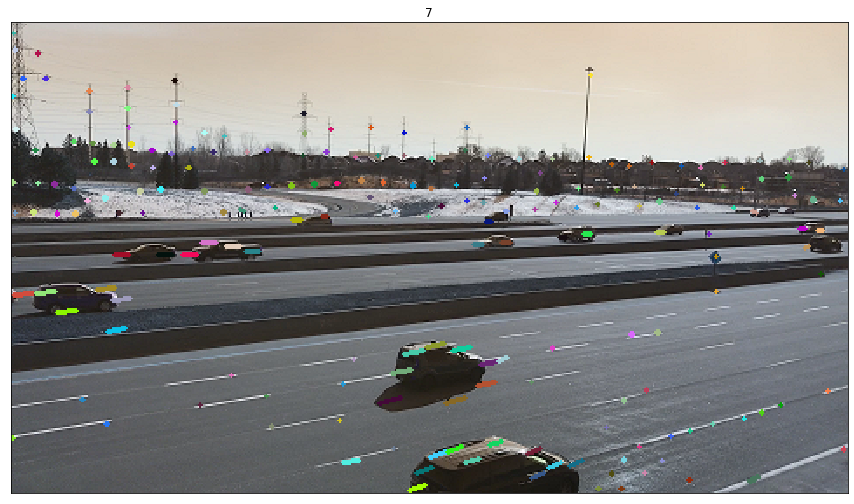

Error Mean:  3.4801707


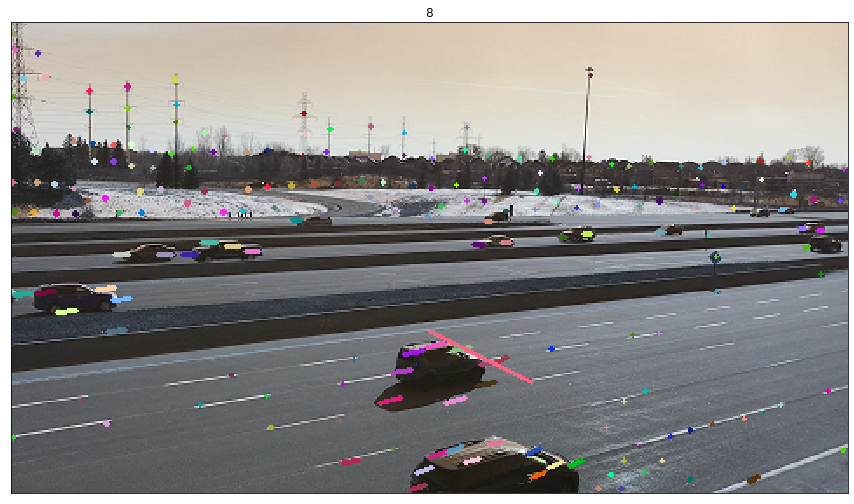

Error Mean:  3.4917088


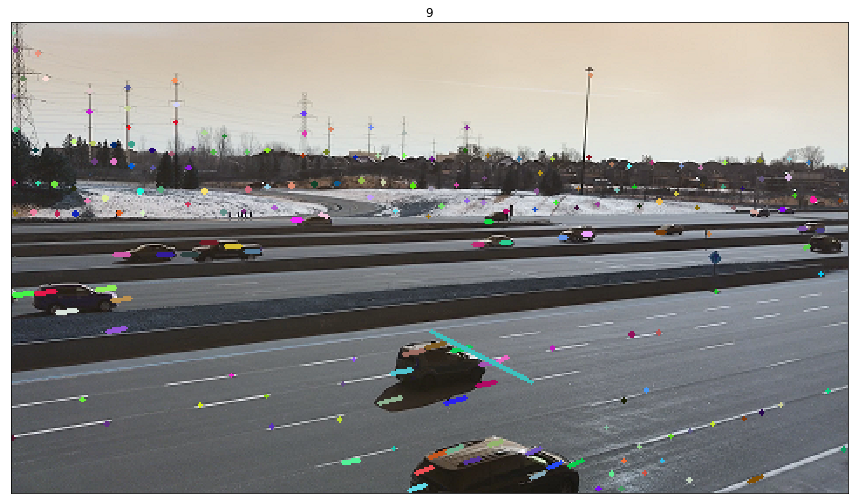

Error Mean:  3.584875


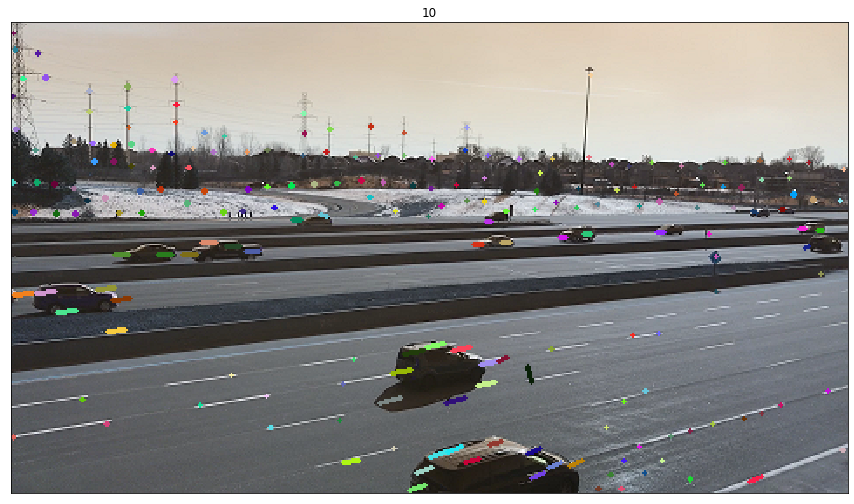

Error Mean:  3.6097653


In [312]:
# read images
img1 = cv2.imread("frame1.png")
img2 = cv2.imread("frame2.png")

# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2"), plt.xticks([]), plt.yticks([])

# parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.01,
                       minDistance = 10,
                       blockSize = 8)
meanerr = []

for k in range(11):
    # parameters for lucas kanade optical flow
    lk_params = dict( winSize = (10,10),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                                 k, 0.03))

    p0 = cv2.goodFeaturesToTrack(img1_gray, **feature_params)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)
    
    # calculate and save the mean errors
    mean = np.mean(err)
    meanerr.append(mean)
    
    # select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # create some random colors
    color = np.random.randint(0, 255, (good_new.shape[0], 3))

    # create a mask image for drawing purposes
    mask = img1.copy()

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)

    plt.figure(figsize=(15,15))
    plt.imshow(mask)
    plt.title(str(k)), plt.xticks([]), plt.yticks([])
    plt.show()
    
    print("Error Mean: ", mean)

From looking at the optical flow of the image based on the different maximum pyramid levels, it seems as though while the lower max levels have some false positives on flow, when the max level hits 3, this issue is resolved. Between max levels 3 to 7, the optical flow identified seems entirely accurate, however at a max level of 8, a large false positive presents itself and remains for the higher max levels. Overall though, the motion captured by the Lucas-Kanade method is pretty accurate for the parameters set, it clearly identifies the motion of the cars with just a few false positives with the traffic lines and road divider. That being said, looking at the means in the error produced by the calcOpticalFlowPyrLK function, the lowest obtained mean is for a max level of 3. For this level, although there are some false positives, it seems as though the number of error vectors are smaller in magnitude. 

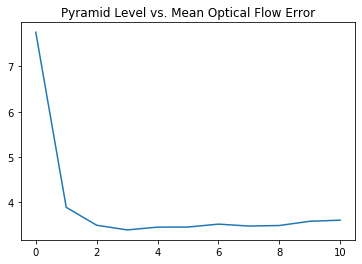

In [319]:
# plot the mean of the error versus the pyramid level
levels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(levels, meanerr)
plt.title("Pyramid Level vs. Mean Optical Flow Error")
plt.show()

From the plot, it can be observed that, as mentioned before, there seems to be a trend with the current set of parameters that indicates a decrease in the mean error for the max pyramid levels between 3 and 4. While it does increase slightly as the max level increases, it is still far more accurate than the max levels prior to 3. Clearly, from the plot, it can be observed that without pyramid layers, the method is riddled with errors. Therefore, it is better to have some pyramid implementation rather than none at all. 